In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter


In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [3]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [4]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)


def CVaRsamp(params, alpha=0.25, n=1000):#n=antal samples
    
    circuit(params)
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    #print(type(expvalue))
    return expvalue

In [5]:
#OBS: se till att du har GPyOpt och pyDOE installerat på datorn ( pip install GPyOpt och pip install pyDOE)

import GPyOpt
from GPyOpt.methods import BayesianOptimization

#@qml.qnode(dev)
#def probability_circuit(params):
#    circuit(params)
#    return qml.probs(wires=qubits)

#probs = probability_circuit(params)

#def success_prob(params):
#    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost)
#    return np.sum(probs[ground_states_i])


def trainGPyOpt( 
			stepsize = 0.01,
			steps = 100,
			heuristic = 'CVaR',
			n = None,
			swarm = 1,
			initial_design_type = 'latin',
			acquisition_type='EI',
			exact_feval = False,
			given_init_params = np.full((2, 1), None),
			plot = False,
			verbose = True,
			gamma_min = 0,
			gamma_max = np.pi*2,
			beta_min = 0,
			beta_max = np.pi*2
			):
	'''
	swarm = 0 and given init params will not swarm. 
	'''

	def wrap_cost(params_list):
		if heuristic == 'CVaR':
			cost_function = CVaRsamp
		elif heuristic == 'success prob':
			cost_function = neg_success_prob   	# we want to maximise the probability
		elif heuristic == 'n-samples':
			n = n
			cost_function = n_samples

		gamma_list = params_list[0][:p]
		beta_list = params_list[0][p:]
		params = np.array([gamma_list, beta_list])
		return cost_function(params)

	#t0 = time.time()

	gamma = []
	beta = []


	for i in range(p):
		gamma += [{'name': 'gamma'+str(i+1),
					'type': 'continuous', 'domain': (gamma_min, gamma_max)}]
		beta += [{'name': 'beta'+str(i+1),
					'type': 'continuous', 'domain': (beta_min, beta_max)}]
	bounds = gamma + beta
	myBopt = GPyOpt.methods.BayesianOptimization(wrap_cost,
													domain=bounds,
													initial_design_numdata = swarm,
													verbosity = verbose,
													initial_design_type = initial_design_type,
													acquisition_type = acquisition_type,
													exact_feval = exact_feval)
	if swarm == 0 and given_init_params.all() != None:
		print('Given init')
		myBopt.X = np.array([given_init_params.flatten().tolist()])
		myBopt.Y = wrap_cost(np.array([given_init_params.flatten().tolist()])).reshape(-1, 1)

	myBopt.run_optimization(max_iter = steps, verbosity = verbose)
	if p == 1:
		myBopt.plot_acquisition()
		plt.savefig('acq.pdf')

	

	if plot:
		myBopt.plot_convergence()
		plt.savefig('conv.pdf')
		plot_cost(cost_vector, new_fig = False, save = True, name = heuristic)


	best_params = np.array([myBopt.x_opt[:p], myBopt.x_opt[p:]])
	params_vector, cost_vector = myBopt.get_evaluations()
	#t1 = time.time()

	print("="*20)
	print("Value of (gamma, beta) that minimises the objective:"+str(myBopt.x_opt))    
	print("Minimum value of the objective: "+str(myBopt.fx_opt)
          #+' Success prob: '+ str(success_prob(best_params))
         )     
	print("="*20)

	return best_params, cost_vector, params_vector

In [6]:
p = 3
best_params, cost_vector, params_vector = trainGPyOpt()

num acquisition: 1, time elapsed: 0.30s
num acquisition: 2, time elapsed: 0.80s
num acquisition: 3, time elapsed: 1.23s
num acquisition: 4, time elapsed: 1.66s
num acquisition: 5, time elapsed: 2.13s
num acquisition: 6, time elapsed: 2.50s
num acquisition: 7, time elapsed: 3.04s
num acquisition: 8, time elapsed: 4.40s
num acquisition: 9, time elapsed: 9.30s
num acquisition: 10, time elapsed: 14.45s
num acquisition: 11, time elapsed: 20.95s
num acquisition: 12, time elapsed: 28.43s
num acquisition: 13, time elapsed: 34.93s
num acquisition: 14, time elapsed: 40.01s
num acquisition: 15, time elapsed: 48.02s
num acquisition: 16, time elapsed: 49.49s
num acquisition: 17, time elapsed: 52.18s
num acquisition: 18, time elapsed: 58.66s
num acquisition: 19, time elapsed: 59.51s
num acquisition: 20, time elapsed: 61.21s
num acquisition: 21, time elapsed: 62.04s
num acquisition: 22, time elapsed: 65.49s
num acquisition: 23, time elapsed: 69.53s
num acquisition: 24, time elapsed: 71.44s
num acquis

Success probability of training:  0.3129178066728612


<Figure size 640x480 with 0 Axes>

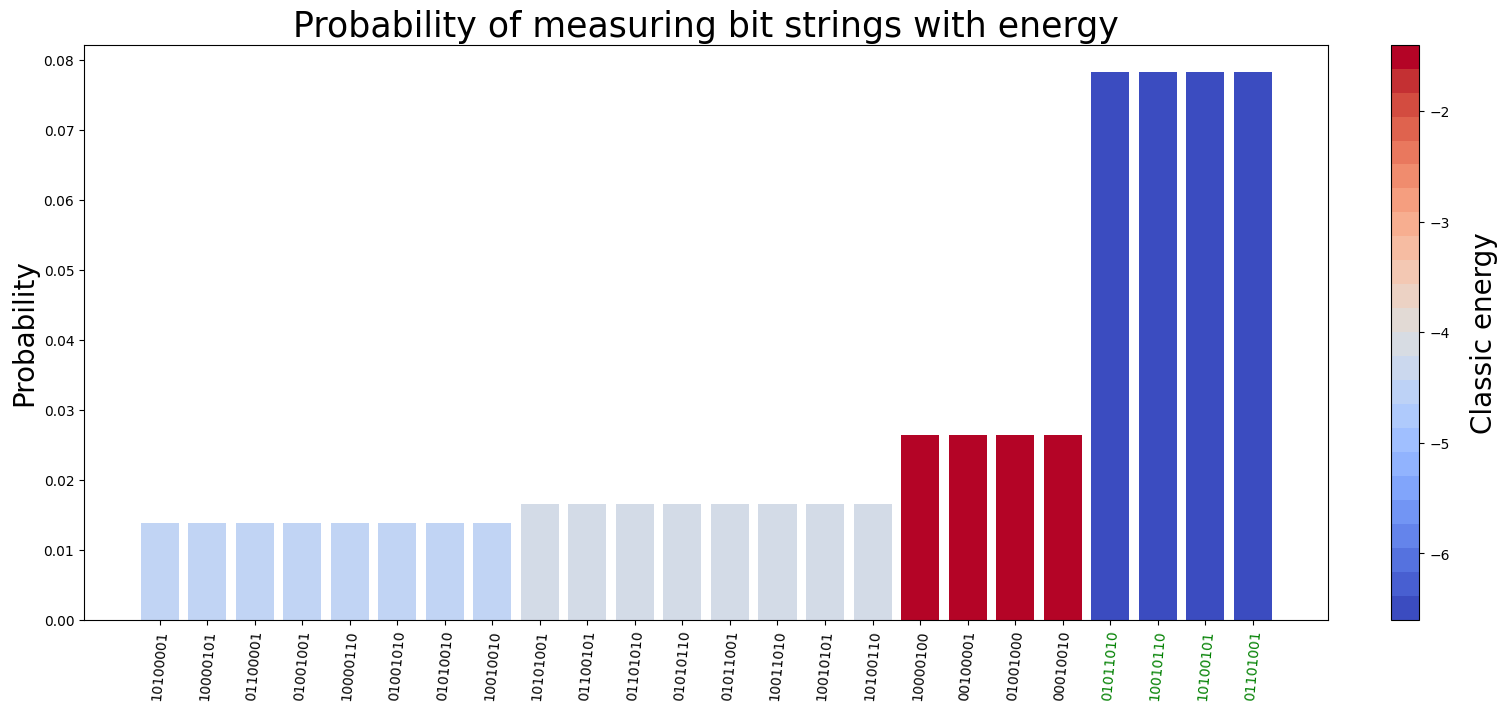

In [9]:
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params)

ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

print('Success probability of training: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings